In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#RUN BEFORE#

In [3]:
#RUN AFTER#

import hls4ml
import pickle

from util.Models import *
from util.Generators import *
from util.Plotting import *


/home/joshualerner/.local/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [4]:

data_path = '/fast_scratch_1/atlas_images/v01-45/'

cell_geo_path = data_path + 'cell_geo.root'

out_path = '/fast_scratch_1/jlerner/data/'

norm = 'log' # 'log', 'std', or 'max'
scaler = None

In [5]:

model = tf.keras.models.load_model(out_path + 'models/GarNet_' + norm)

with open(out_path + 'models/qGarNet_' + norm + '/history.pickle', "rb") as file:
    history = pickle.load(file)

if norm == 'std':
    with open(out_path + 'models/GarNet_' + norm + '/scaler.pickle', 'rb') as file:
        scaler = pickle.load(file)
        
qmodel = tf.keras.models.load_model(out_path + 'models/qGarNet_' + norm)


2023-06-20 13:03:37.195351: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-20 13:03:37.195417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6991 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


In [6]:
if norm == 'max':
    name = 'garnet_' + norm + '_100'
else:
    name = 'garnet_' + norm

test_file_list = ([[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] for i in range(232, 264)],
                  [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] for i in range(232, 264)])

test_generator = garnetDataGenerator(test_file_list,
                                     cell_geo_path,
                                     batch_size=20000,
                                     normalizer=(norm, scaler),
                                     name=name,
                                     labeled=True,
                                     preprocess=False,
                                     output_dir=out_path + 'test/')

x, y = next(test_generator.generator())

In [7]:
config = {}
config['Model'] = {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}
config['LayerType'] = {'GarNetStack': {}, 'Dense': {}}
config['LayerName'] = {'input_1': {}, 'input_2': {}, 'garnet': {}, 'regression': {}, 'classification': {}}

config['LayerType']['GarNetStack'] = {'ReuseFactor': 1,
                                      'Trace': True,
                                      'Precision': {'default': 'ap_fixed<16, 6, AP_RND, AP_SAT>',
                                                    #'edge_weight': 'ap_ufixed<10, 0, AP_TRN, AP_SAT>',
                                                    #'edge_weight_aggr': 'ap_ufixed<17, 7>, AP_TRN, AP_SAT>',
                                                    #'aggr': 'ap_fixed<20, 10, AP_TRN, AP_SAT>',
                                                    #'norm': 'ap_ufixed<16, 4, AP_TRN, AP_SAT>',
                                                    'result': 'ap_fixed<16, 6>'}}

# compile writes incorrect [norm_t, edge_weight_t, edge_weight_aggr_t, and aggr_t] type defs

config['LayerType']['Dense'] = {'Trace': True,
                                'Precision': {'accum': 'ap_fixed<18, 8>',
                                              #'weight': 'ap_fixed<16, 6>',
                                              'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}}

config['LayerName']['input_1'] = {'Precision': {'result': 'ap_fixed<14, 5, AP_RND, AP_SAT>'}}

config['LayerName']['input_2'] = {'Precision': {'result': 'ap_uint<10>'}}

config['LayerName']['regression'] = {'Precision': {#'weight': 'ap_fixed<16, 6, AP_RND, AP_SAT>',
                                                   'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}}

#config['LayerName']['classification'] = {'Precision': {'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}}

print("-----------------------------------")
print("Configuration")
config

-----------------------------------
Configuration


{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'},
 'LayerType': {'GarNetStack': {'ReuseFactor': 1,
   'Trace': True,
   'Precision': {'default': 'ap_fixed<16, 6, AP_RND, AP_SAT>',
    'result': 'ap_fixed<16, 6>'}},
  'Dense': {'Trace': True,
   'Precision': {'accum': 'ap_fixed<18, 8>',
    'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}}},
 'LayerName': {'input_1': {'Precision': {'result': 'ap_fixed<14, 5, AP_RND, AP_SAT>'}},
  'input_2': {'Precision': {'result': 'ap_uint<10>'}},
  'garnet': {},
  'regression': {'Precision': {'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}},
  'classification': {}}}

In [8]:
# config = {}
# config['Model'] = {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}
# config['LayerType'] = {'GarNetStack': {}, 'Dense': {}}

# config['LayerType']['GarNetStack'] = {'Trace': True}

# config['LayerType']['Dense'] = {'Trace': True}

# print("-----------------------------------")
# print("Configuration")
# config

In [9]:
# config = {}
# config['Model'] = {'Precision': 'ap_fixed<32,8>', 'ReuseFactor': 1, 'Strategy': 'Latency'}
# config['LayerType'] = {'GarNetStack': {}, 'Dense': {}}

# config['LayerType']['GarNetStack'] = {'Trace': True}

# config['LayerType']['Dense'] = {'Trace': True}

# print("-----------------------------------")
# print("Configuration")
# config

In [10]:

hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, 
                                                       output_dir='/home/joshualerner/start_tf/PionReconstruction/data/', 
                                                       part='xcku115-flvb2104-2-i')

qhls_model = hls4ml.converters.convert_from_keras_model(qmodel, hls_config=config, 
                                                        output_dir='/home/joshualerner/start_tf/PionReconstruction/data/', 
                                                        part='xcku115-flvb2104-2-i')

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 4]], output shape: [None, 128, 4]
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: garnet, layer type: GarNetStack, input shapes: [[None, 128, 4], [None, 1]], output shape: [None, 16]
Layer name: dense, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 8]
Layer name: classification, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 2]
Layer name: regression, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 1]
Creating HLS model
Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 4]], output shape: [None, 128, 4]
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: garnet, layer type:

In [11]:
hls_model.compile()
keras_pred = model.predict(x)
hls_pred = hls_model.predict(x)

Writing HLS project
Done


2023-06-20 13:04:14.588070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
qhls_model.compile()
qkeras_pred = qmodel.predict(x)
qhls_pred = qhls_model.predict(x)

Writing HLS project
Done


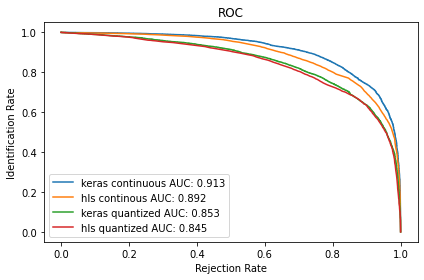

In [13]:
ROC = Plotter(roc, 
              preds=[keras_pred[0][:,0], hls_pred[0][:,0],
                     qkeras_pred[0][:,0], qhls_pred[0][:,0]], 
              targets=[y['classification'][:,0], y['classification'][:,0], 
                       y['classification'][:,0], y['classification'][:,0]],
              labels=['keras continuous', 'hls continous',
                      'keras quantized', 'hls quantized'])
ROC.show()

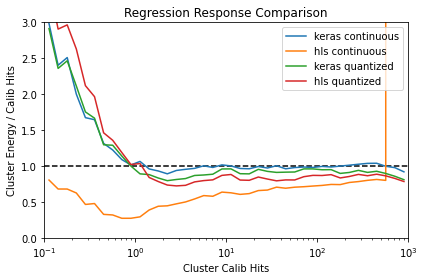

In [14]:
if norm == 'log':
    keras_scaled_pred = np.exp(keras_pred[-1]*10).reshape(-1,)
    hls_scaled_pred = np.exp(hls_pred[-1]*10).reshape(-1,)
    qkeras_scaled_pred = np.exp(qkeras_pred[-1]*10).reshape(-1,)
    qhls_scaled_pred = np.exp(qhls_pred[-1]*10).reshape(-1,)
    scaled_target = np.exp(y['regression']*10).reshape(-1,)
elif norm == 'std':
    keras_scaled_pred = scaler.inverse_transform(keras_pred[-1]).reshape(-1,)
    hls_scaled_pred = scaler.inverse_transform(hls_pred[-1]).reshape(-1,)
    scaled_target = scaler.inverse_transform(np.reshape(y['regression'], (-1, 1))).reshape(-1,)
elif norm == 'max':
    keras_scaled_pred = keras_pred[-1].reshape(-1,) * 100
    hls_scaled_pred = hls_pred[-1].reshape(-1,) * 100
    scaled_target = y['regression'].reshape(-1,) * 100

reg = Plotter(regResponseOverlay, 
              preds=[keras_scaled_pred, hls_scaled_pred,
                     qkeras_scaled_pred, qhls_scaled_pred], 
              targets=[scaled_target, scaled_target, scaled_target, scaled_target],
              stat=['mean'],
              labels=['keras continuous', 'hls continuous', 'keras quantized', 'hls quantized'])
reg.show()

Recompiling myproject with tracing
Writing HLS project
Done


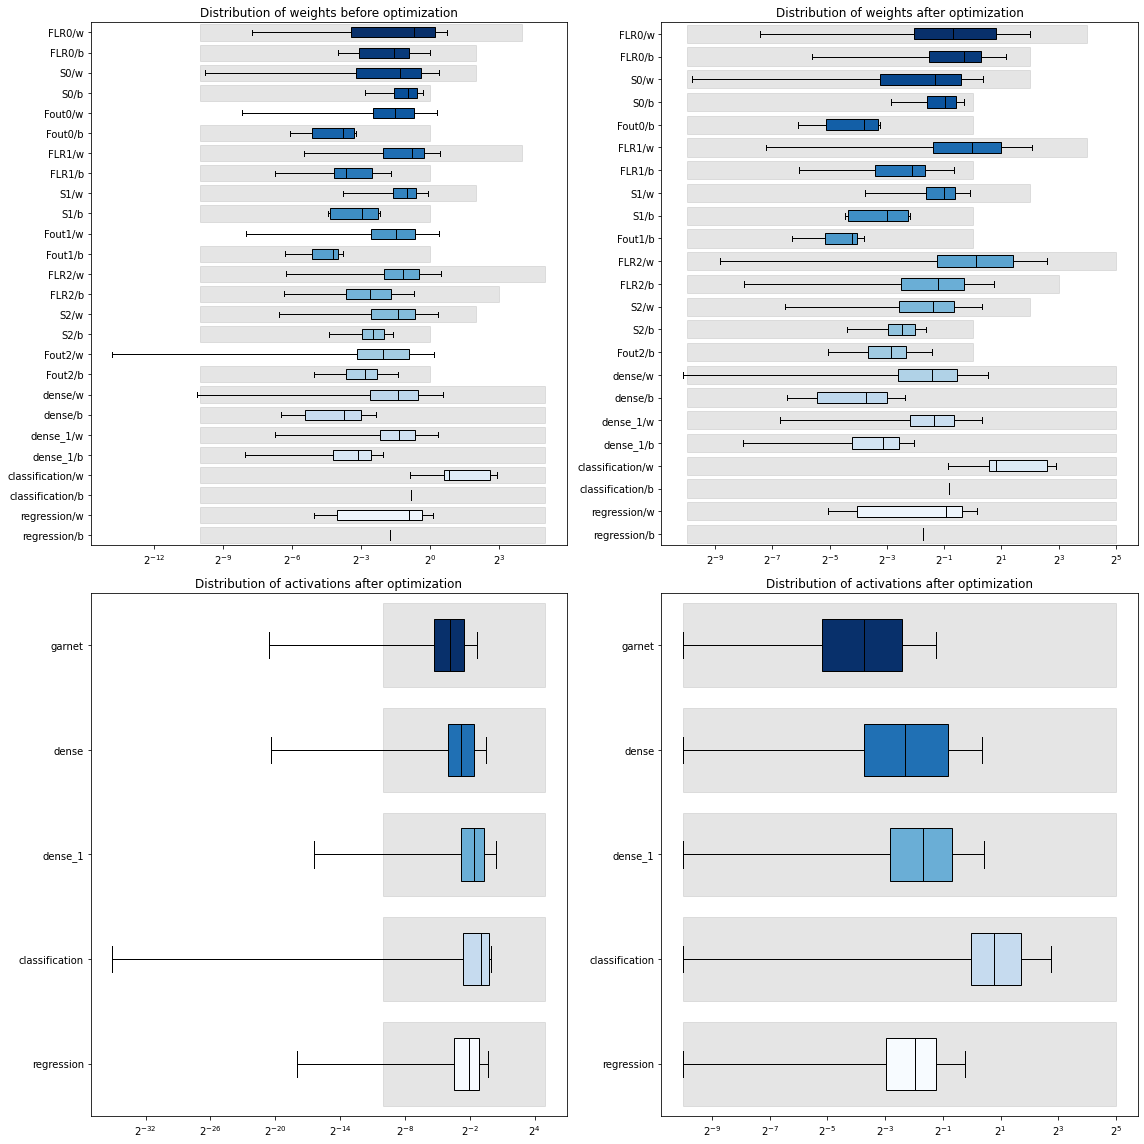

In [15]:
prof = Plotter(weight_profile, model=model, hls_model=hls_model, x=x)
prof.show()

In [16]:

### hls appears to struggle with log normalized energy values greater than 1... bounded by (-10, 8]
### standard scaler is neither successful nor bounded by [-1, 1]
### max scaler is not successful, but should be bounded by [-1, 1]
### issues with relative error: fractional energies :(

In [17]:
### understand fixed point by plotting inputs and targets
### try cutting 0 - 100 √
### try qkeras
### try classify only
### try increase precision to 32?